In [24]:
import os,sys, glob, math
import numpy as np
#import pyrosetta

import collections

%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update({'font.size': 14})
import matplotlib.pylab as plt


#pyrosetta.init("-beta")


In [25]:
def coordinate_frame(xyz1, xyz2, xyz3):
    a = xyz1; b = xyz2; c = xyz3

    e1 = a - b
    e1 /= np.linalg.norm(e1)

    e3 = np.cross(e1, c - b)
    e3_norm = np.linalg.norm(e3)

    if e3_norm == 0:
        raise ValueError('atom1, atom2, and atom3 are colinear!')

    e3 /= e3_norm

    e2 = np.cross(e3, e1)

    matrix = np.array([[e1[0], e2[0], e3[0]],
                       [e1[1], e2[1], e3[1]],
                       [e1[2], e2[2], e3[2]]])
    vector = a

    return matrix, vector

def cbeta_from_ca_c_n(ca_xyz, c_xyz, n_xyz):
    ## if problems, check angle (110.35) and length ()
    epsilon = 0.00001
    matrix, vector = coordinate_frame(ca_xyz, c_xyz, n_xyz)
    phi, theta, d = math.radians(122.0), math.radians(180 - 110 + epsilon), 1.5
    v1_xyz = matrix @ np.array([d * math.cos(theta), d * math.sin(theta) * math.cos(phi), d * math.sin(theta) * math.sin(phi)]) + vector
    return pyrosetta.rosetta.numeric.xyzVector_double_t(v1_xyz[0], v1_xyz[1], v1_xyz[2])

def res1_pointed_at_res2(res1, res2, angle_cutoff, dist_cutoff):
    import math
    is_pointed_at = False
    dist_squared = dist_cutoff * dist_cutoff

    if res1.type().has("CB") and res2.type().has("CB"):
        CA_position = res1.atom("CA").xyz()
        CB_position = res1.atom("CB").xyz()
        dest_position = res2.atom("CB").xyz()

    elif res1.type().has("CB") and res2.type().has("CA") and res2.type().has("C") and res2.type().has("N"):
        CA_position = res1.atom("CA").xyz()
        CB_position = res1.atom("CB").xyz()
        dest_position = cbeta_from_ca_c_n(res2.atom("CA").xyz(), res2.atom("C").xyz(), res2.atom("N").xyz())

    elif res1.type().has("CA") and res1.type().has("C") and res1.type().has("N") and res2.type().has("CB"):
        CA_position = res1.atom("CA").xyz()
        CB_position = cbeta_from_ca_c_n(res1.atom("CA").xyz(), res1.atom("C").xyz(), res1.atom("N").xyz())
        dest_position = res2.atom("CB").xyz()

    elif res1.type().has("CA") and res1.type().has("C") and res1.type().has("N") and res2.type().has("CA") and res2.type().has("C") and res2.type().has("N"):
        CA_position = res1.atom("CA").xyz()
        CB_position = cbeta_from_ca_c_n(res1.atom("CA").xyz(), res1.atom("C").xyz(), res1.atom("N").xyz())
        CB_position2 = cbeta_from_ca_c_n(res2.atom("CA").xyz(), res2.atom("C").xyz(), res2.atom("N").xyz())
        dest_position = CB_position2

    else:
        print("currently only works for protein residues with CB and/or CA")
        return is_pointed_at


    cbvector = CB_position - CA_position
    res1_vector = cbvector.normalize()

    # see if residues are close enough
    if CB_position.distance_squared( dest_position ) <= dist_squared:
        base_to_dest = (dest_position - CB_position).normalize()
        r1_dot_r2 = pyrosetta.rosetta.numeric.dot(res1_vector, base_to_dest)
        costheta = math.cos(math.radians(angle_cutoff))
        if r1_dot_r2 > costheta:
            is_pointed_at = True
    return is_pointed_at

def get_interface_by_vector(p, residue_set1, residue_set2, vector_angle_cutoff=75.0, vector_dist_cutoff=8.0):
    vector_to_return = []

    # returns all resi1 pointing at resi2
    new_residue_set1 = []
    for i in range(len(residue_set1)):
        new_residue_set1.append([residue_set1[i], p.residue(residue_set1[i])])
    new_residue_set2 = []
    for i in range(len(residue_set2)):
        new_residue_set2.append([residue_set2[i], p.residue(residue_set2[i])])

    new_residue_set1
    new_residue_set2
    for resi in new_residue_set1:
        for resj in new_residue_set2:
            if resi[0] in vector_to_return:
                continue
            if resi[0] == resj[0]:
                continue
            if res1_pointed_at_res2(resi[1], resj[1], vector_angle_cutoff, vector_dist_cutoff):
                #print("{} pointed at {}".format(resi[0], resj[0]))
                vector_to_return.append(resi[0])

    return vector_to_return

def get_interface_by_vector_reverse(p, residue_set1, residue_set2, vector_angle_cutoff=75.0, vector_dist_cutoff=8.0):
    vector_to_return = []

    # returns all resi1 pointed at by resi2
    new_residue_set1 = []
    for i in range(len(residue_set1)):
        new_residue_set1.append([residue_set1[i], p.residue(residue_set1[i])])
    new_residue_set2 = []
    for i in range(len(residue_set2)):
        new_residue_set2.append([residue_set2[i], p.residue(residue_set2[i])])

    new_residue_set1
    new_residue_set2
    for resi in new_residue_set1:
        for resj in new_residue_set2:
            if resi[0] in vector_to_return:
                continue
            if resi[0] == resj[0]:
                continue
            if res1_pointed_at_res2(resj[1], resi[1], vector_angle_cutoff, vector_dist_cutoff):
                #print("{} pointed at {}".format(resi[0], resj[0]))
                vector_to_return.append(resi[0])

    return vector_to_return

In [26]:
pdbs_d = glob.glob("/home/drhicks1/Derroids_3/*pdb")
pdbs_t = glob.glob("/home/drhicks1/torrick_dimers_06252020/best/*pdb")

In [27]:
pdbs = pdbs_d + pdbs_t

In [1]:
# aas = []
# for pdb in pdbs:
#     pose = pyrosetta.pose_from_pdb(pdb)
#     res1 = list( range(pose.chain_begin(1), pose.chain_end(1)+1) )
#     res2 = list( range(pose.chain_begin(2), pose.chain_end(2)+1) )
#     iface_res = list(set(get_interface_by_vector(pose, res1, res2) + get_interface_by_vector_reverse(pose, res1, res2)))
#     for resi in iface_res:
#         aa = pose.residue(resi).name1()
#         aas.append(aa)

E 0.1323069015466567
A 0.08461053221812065
K 0.06441287790290173
S 0.042579785991308815
L 0.22141488715480584
R 0.08579038362693332
I 0.0520185972618102
Y 0.03946077286108126
T 0.037533292836783326
D 0.02759216859025279
F 0.04150506985654876
P 0.00385496004859586
Q 0.05068688379047708
N 0.019379935517031915
W 0.007499649549086491
V 0.0389584598850521
H 0.03874818933694687
M 0.009135087145460493
G 0.0025115648801457874
polar 0.18892808747254802
charged 0.31010233166674456
nonpolar 0.5009695808607074


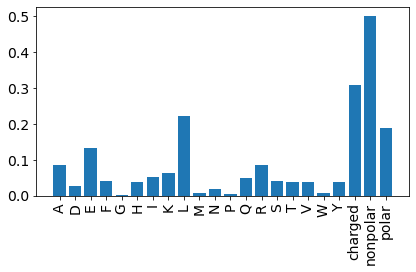

In [26]:
npys = glob.glob("/home/drhicks1/Derroids_3/interface/*npy")

aas = []

for npy in npys:
    npy = np.load(npy, allow_pickle=True)
    aas = aas + list(npy)

occurrences = collections.Counter(aas)

polar = "HNQST"
charged = "DEKR"
nonpolar = "AFILMVWYGPC"

polar = [x for x in polar]
charged = [x for x in charged]
nonpolar = [x for x in nonpolar]

polar_count = 0
charged_count = 0
nonpolar_count = 0

for key in occurrences:
    if key in polar:
        polar_count += occurrences[key]
    elif key in charged:
        charged_count += occurrences[key]
    elif key in nonpolar:
        nonpolar_count += occurrences[key]

occurrences["polar"] = polar_count
occurrences["charged"] = charged_count
occurrences["nonpolar"] = nonpolar_count

for key in occurrences:
    occurrences[key] = occurrences[key]/len(aas)
    print(f"{key} {occurrences[key]}")

lists = sorted(occurrences.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.bar(x, y)
mpl.rcParams.update({'font.size': 14})
plt.xticks(rotation=90)

plt.tight_layout()

plt.savefig('/home/drhicks1/Derroids_3/interface/interface_composition.png', dpi=300)

plt.show()
